In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import projectScript as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.python.tpu.ops.gen_xla_ops import xla_sparse_dense_matmul_grad_with_adagrad_momentum_and_static_buffer_size

2024-12-01 13:44:06.492984: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 13:44:06.495618: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 13:44:06.502481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 13:44:06.513077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 13:44:06.516312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 13:44:06.525715: I tensorflow/core/platform/cpu_feature_gu

# Loading data

In [2]:
data = pd.read_csv("temp.csv")

# removing the longitude, latitude, and ocean_proximity
data = data.drop(['Unnamed: 0'], axis=1)
data = data.dropna()
data = data.reset_index(drop=True)
data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [3]:
# defining x and y
y = data['medv']
x = data.drop(['medv'], axis=1)
x = x.rename(columns=dict(zip(x.columns.values, ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13'])))
x_base = x.copy()
y_base = y.copy()
n, p = x.shape
p += 1

vif = ps.check_multicollinearity(x, x.columns)
display(vif)

{'x1': 1.7921915474332395,
 'x2': 2.298758178749442,
 'x3': 3.9915964183460297,
 'x4': 1.0739953275537877,
 'x5': 4.393719847577495,
 'x6': 1.933744435783257,
 'x7': 3.1008255128153372,
 'x8': 3.95594490637273,
 'x9': 7.484496335274466,
 'x10': 9.008553947597061,
 'x11': 1.7990840492488984,
 'x12': 1.3485210764063758,
 'x13': 2.9414910780919348}

# Exploratory data analysis

## Scatter plots

/tmp/ipykernel_19205/4249357941.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


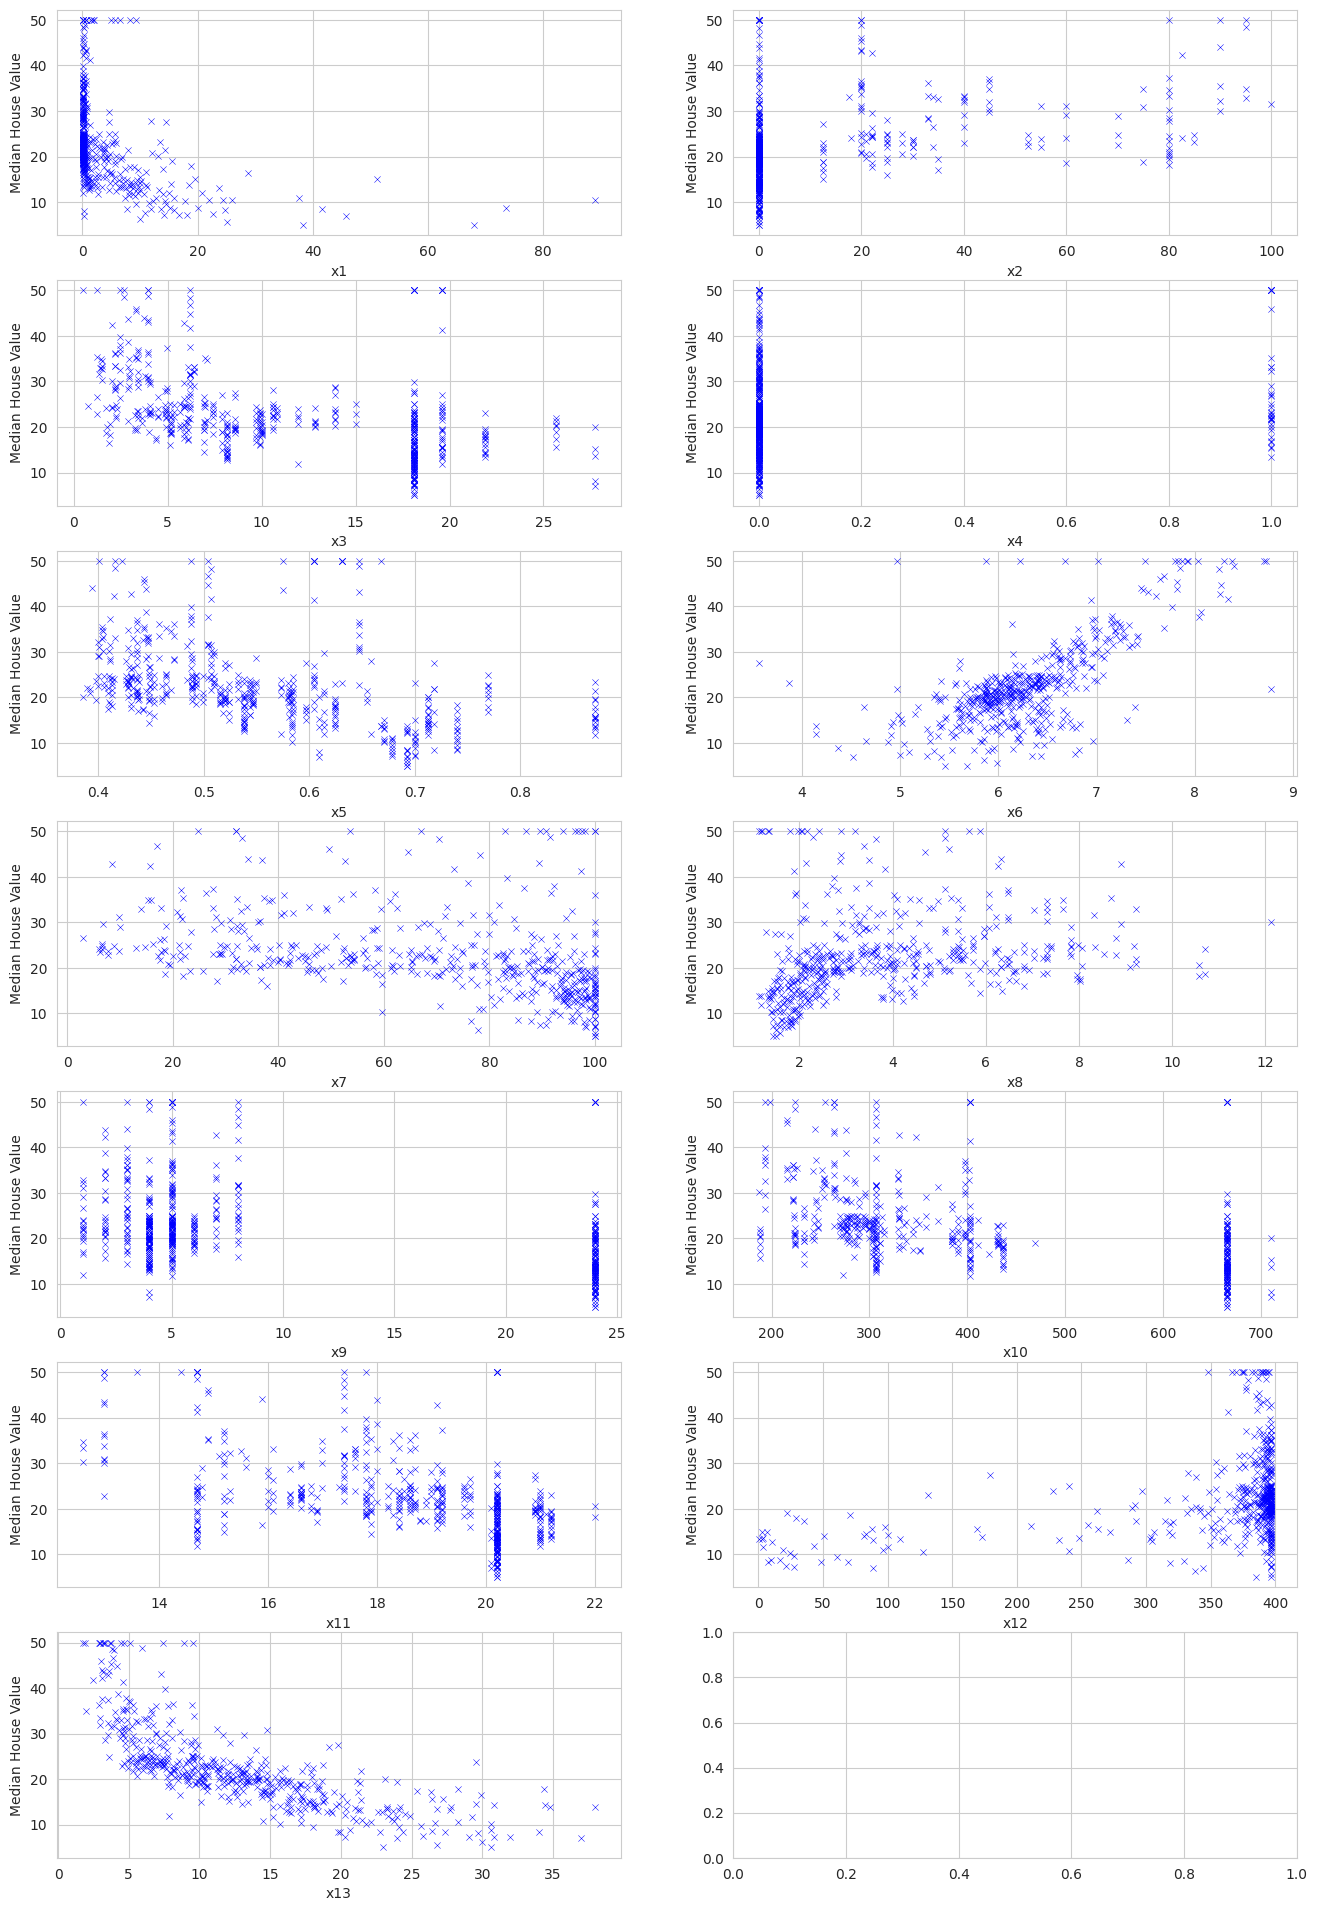

In [4]:
fig, ax = plt.subplots(7, 2, figsize=(16, 24))

for i in range(6):
    for j in range(2):
        ax[i, j].set_title("")
        ax[i, j].set_ylabel("Median House Value")
        ax[i, j].set_xlabel(f"{x.columns[2*i+j]}")
        sns.scatterplot(x=x[x.columns[2*i+j]], y=y, ax=ax[i, j], s=20, marker="x", color="blue")

ax[6, 0].set_title("")
ax[6, 0].set_ylabel("Median House Value")
ax[6, 0].set_xlabel(f"{x.columns[-1]}")
sns.scatterplot(x=x[x.columns[-1]], y=y, ax=ax[6, 0], s=20, marker="x", color="blue")
# fig.suptitle("Predictor vs Target Variable Scatter Plots")
fig.show()

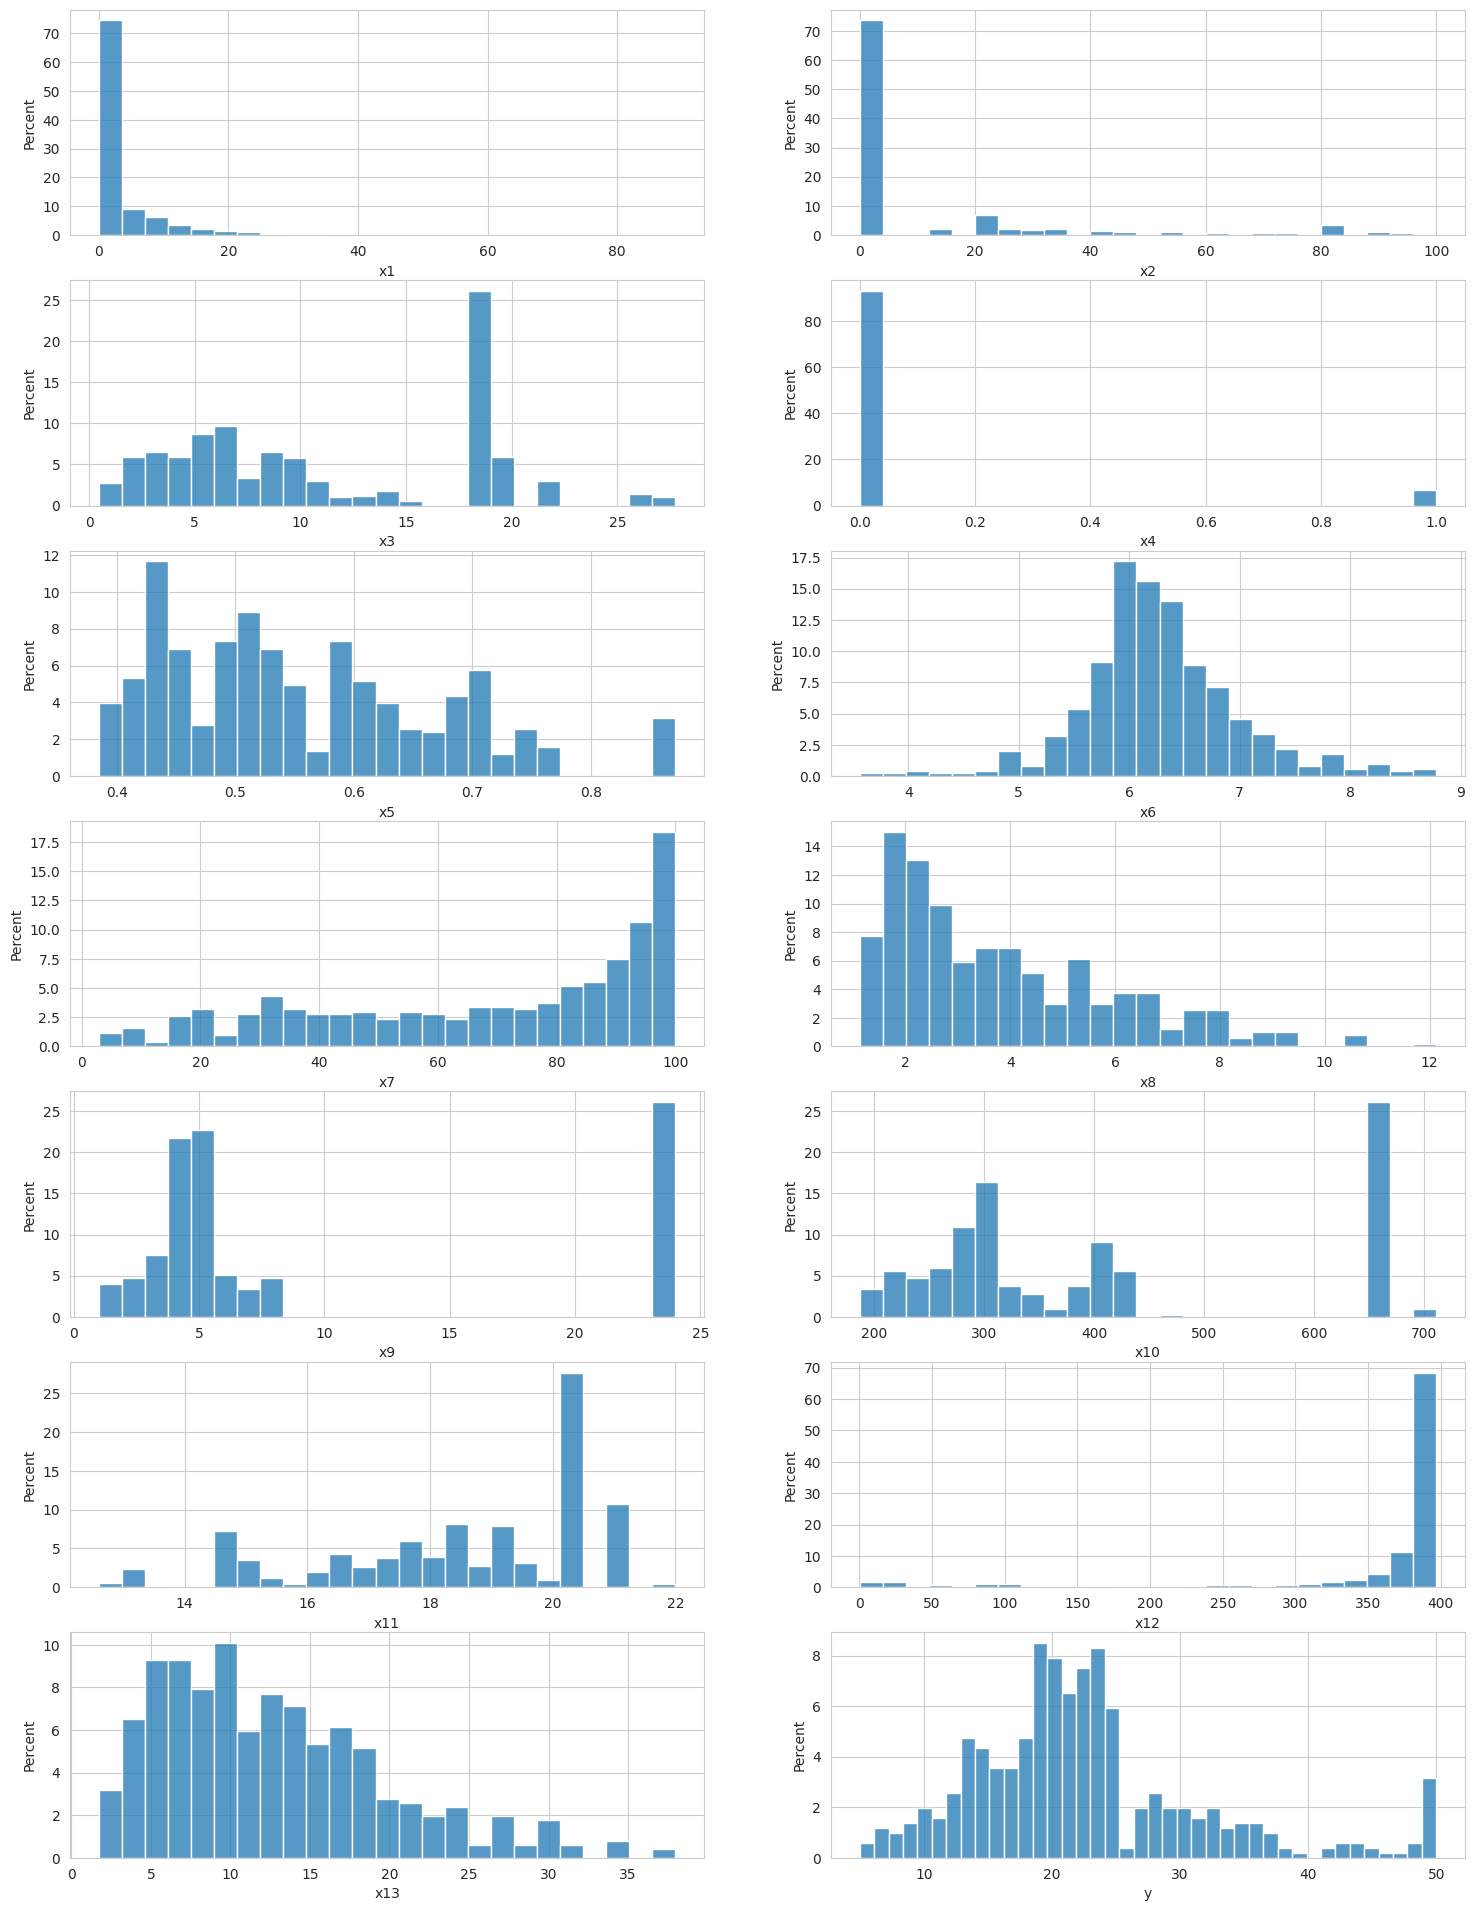

In [5]:
fig, ax = plt.subplots(7, 2, figsize=(18, 24))

for i in range(13):
    # if i == 4 and j == 1:
    #     continue
    ax[i//2, i%2].set_title("")
    ax[i//2, i%2].set_xlabel(f"{x.columns[i]}")
    sns.histplot(x=x[x.columns[i]], ax=ax[i//2, i%2], bins=25, stat='percent')

# fig.suptitle("Predictor Distributions")
sns.histplot(x=y, ax=ax[6, 1], bins=40, stat='percent')
ax[6, 1].set_xlabel(f"y");

## Correlations

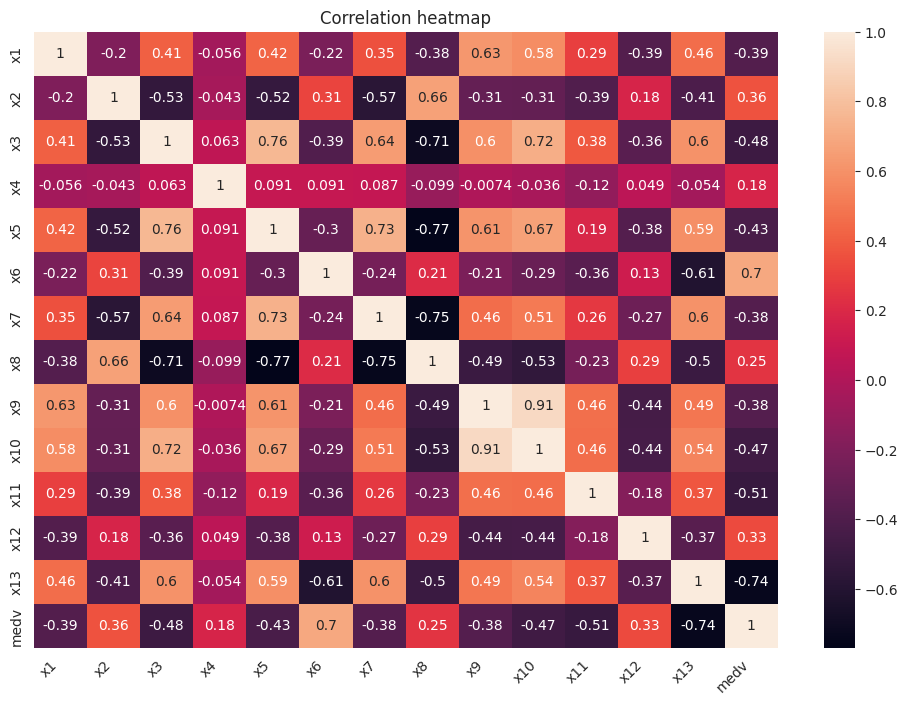

In [6]:
temp = x.copy()
temp['medv'] = y
plt.figure(figsize=(12, 8))
sns.heatmap(temp.corr(), annot=True)
plt.title("Correlation heatmap")
plt.xticks(rotation=45, ha="right");

# Regular modeling

## Model selection

In [7]:
ps.model_selection(x, y)
# best model features:[x1, x2, x4, x5, x6, x8, x9, x10, x11, x12, x13]
# best model stats: r2_adj: 73.480577, aic: 1585.760592, sbc:1636.479032, k = 12, ck=10.114548

,features,beta_hat,sse,sst,ssr,mse,r2,r2_adj,aic_met,sbc_met,k,ck_met
0,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11,...","[36.459488385089955, -0.1080113578367983, 0.04...",11078.784578,42716.295415,31637.510837,22.517855,74.064266,73.378973,1589.642798,1648.814312,14,14.000000
1,[x1],"[24.03310617412388, -0.41519027791509083]",36275.512356,42716.295415,6440.783059,71.975223,15.078047,14.909551,2165.814935,2174.268009,2,1108.966614
2,[x2],"[20.917579117799832, 0.14213999415535442]",37166.558224,42716.295415,5549.737191,73.743171,12.992084,12.819450,2178.093765,2186.546838,2,1148.537251
3,[x3],"[29.75489651192849, -0.6484900536157151]",32721.108150,42716.295415,9995.187265,64.922834,23.399003,23.247017,2113.634928,2122.088002,2,951.118354
4,[x4],"[22.093842887473464, 6.346157112526537]",41404.216144,42716.295415,1312.079271,82.151223,3.071613,2.879295,2232.728270,2241.181344,2,1336.728265
...,...,...,...,...,...,...,...,...,...,...,...,...
8186,"[x1, x2, x3, x4, x6, x7, x8, x9, x10, x11, x12...","[23.4999994280817, -0.09889831260869322, 0.048...",11565.940252,42716.295415,31150.355163,23.460325,72.923822,72.264767,1609.417301,1664.362278,13,33.634196
8187,"[x1, x2, x3, x5, x6, x7, x8, x9, x10, x11, x12...","[36.89195979693213, -0.11313907811822563, 0.04...",11297.754935,42716.295415,31418.540480,22.916339,73.551651,72.907878,1597.546255,1652.491231,13,21.724299
8188,"[x1, x2, x4, x5, x6, x7, x8, x9, x10, x11, x12...","[36.363882007057306, -0.10841906845960328, 0.0...",11081.301246,42716.295415,31634.994169,22.477284,74.058375,73.426936,1587.757729,1642.702706,13,12.111763
8189,"[x1, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12...","[36.86325933562823, -0.09832511643053385, -0.0...",11336.277557,42716.295415,31380.017858,22.994478,73.461468,72.815500,1599.268658,1654.213634,13,23.435058


## Model fitting

In [8]:
# fitting the model
x = x[['x1', 'x2', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']]
features, beta_hat, y_hat, e, sse, sst, ssr, mse, r2, r2_adj, aic_met, sbc_met, p, ck_met = ps.fit_model(x, y)
print(dict(zip(['r2', 'r2_adj', 'aic_met', 'sbc_met'], [r2, r2_adj, aic_met, sbc_met])))
print(f"Beta hat: {beta_hat}")

{'r2': 74.05822802569575, 'r2_adj': 73.48057723274566, 'aic_met': 1585.7605922219332, 'sbc_met': 1636.4790322533827}
Beta hat: [36.34114500447143, -0.10841334532815937, 0.04584492919512657, 2.7187163028352526, -17.376023429420965, 3.801578840106073, -1.4927114604467182, 0.29960845367682853, -0.011777973465827554, -0.946524570309823, 0.009290844771995387, -0.5225534568578852]


## Residual plots

/tmp/ipykernel_19205/4027290953.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


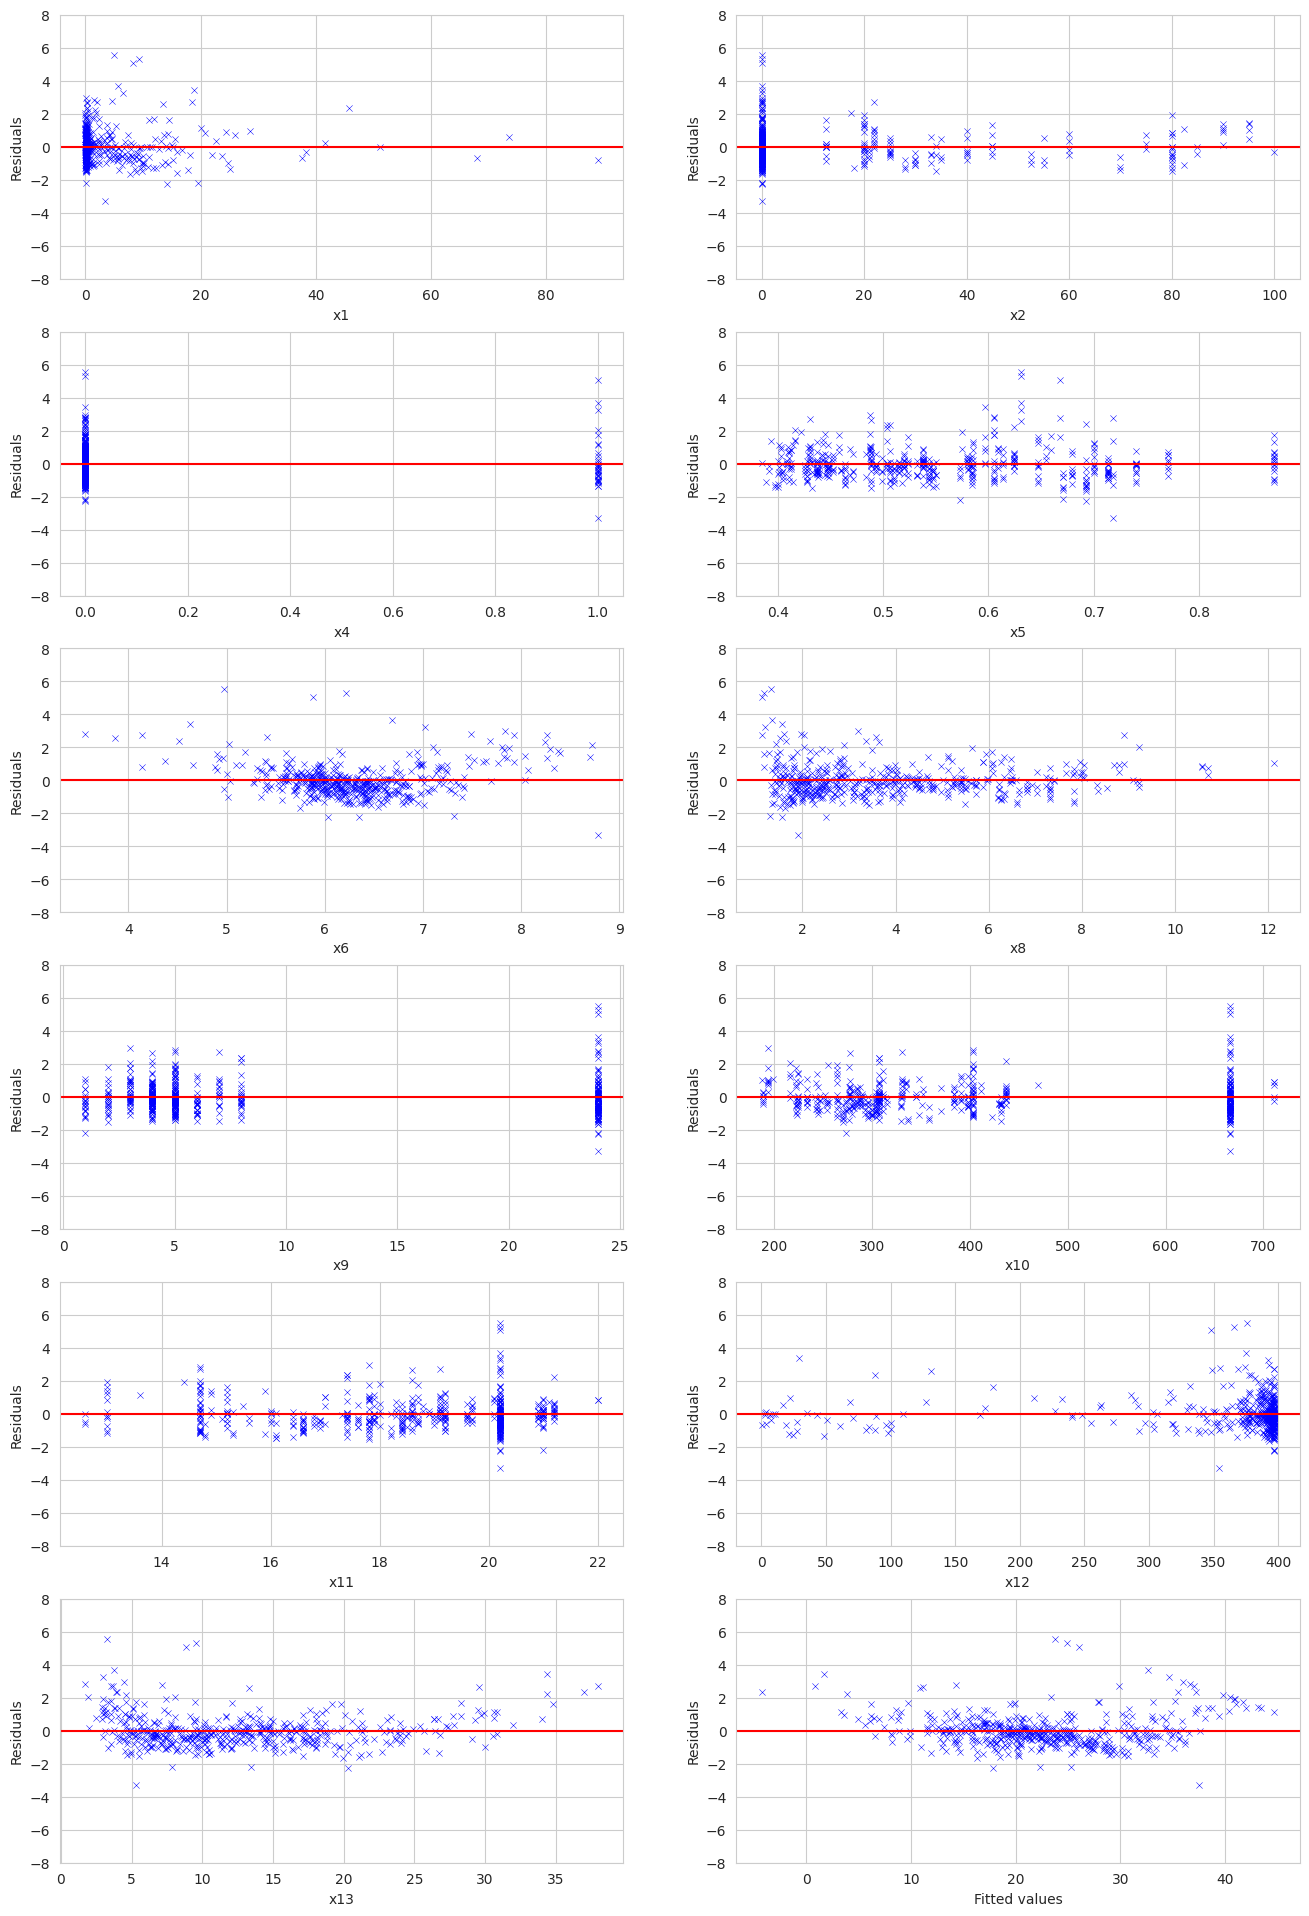

In [9]:
fig, ax = plt.subplots(6, 2, figsize=(16, 24))
e_star = e/np.sqrt(mse)

for i in range(11):
    ax[i//2, i%2].set_xlabel(f"{x.columns[i]}")
    ax[i//2, i%2].set_ylabel(f"Residuals")
    sns.scatterplot(x=x[x.columns[i]], y=e_star, ax=ax[i//2, i%2], s=20, marker="x", color="blue")
    ax[i//2, i%2].axhline(y=0, color='r')
    ax[i//2, i%2].set_ylim(-8, 8)
sns.scatterplot(x=y_hat, y=e_star, ax=ax[5, 1], s=20, marker="x", color="blue")
ax[5, 1].set_ylim(-8, 8)
ax[5, 1].axhline(y=0, color='r')
ax[5, 1].set_xlabel(f"Fitted values")
ax[5, 1].set_ylabel(f"Residuals")

fig.show()

## Probability plot

Text(0.5, 1.0, 'Residuals Box Plot')

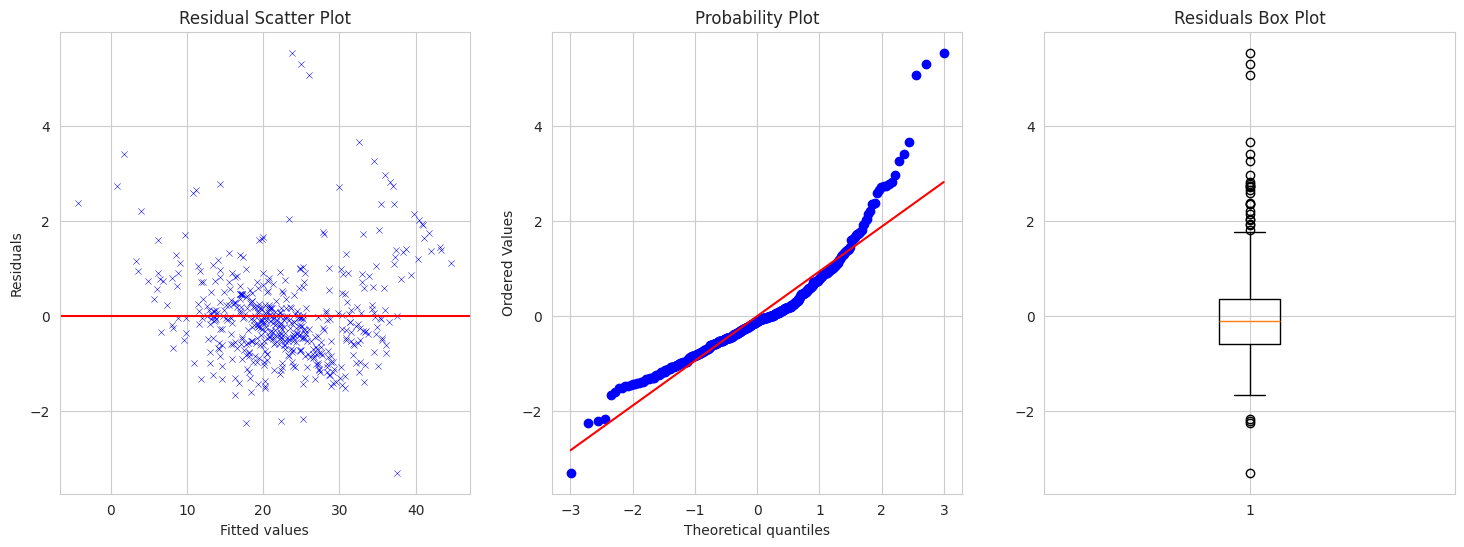

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# ax.set_ylim(-8, 8)
ax[0].axhline(y=0, color='r')
ax[0].set_xlabel(f"Fitted values")
ax[0].set_ylabel(f"Residuals")
ax[0].set_title("Residual Scatter Plot")
sns.scatterplot(x=y_hat, y=e_star, ax=ax[0], s=20, marker="x", color="blue")

stats.probplot(e_star, plot=ax[1])
ax[2].boxplot(e_star);
ax[2].set_title("Residuals Box Plot")

## Outlier detection

In [11]:
x_outliers, y_outliers, influential_outliers, r, t = ps.outlier_detection(x, y)
print(dict(zip(['x outliers', 'y outliers', 'influential outliers'], [len(x_outliers), len(y_outliers), len(influential_outliers)])))
print(influential_outliers)

{'x outliers': 42, 'y outliers': 3, 'influential outliers': 16}
[162, 163, 204, 364, 365, 367, 368, 369, 370, 371, 372, 405, 380, 412, 253, 414]


## Residuals for outlier detection

<Axes: xlabel='Fitted Values', ylabel='Externally Studentized Residuals'>

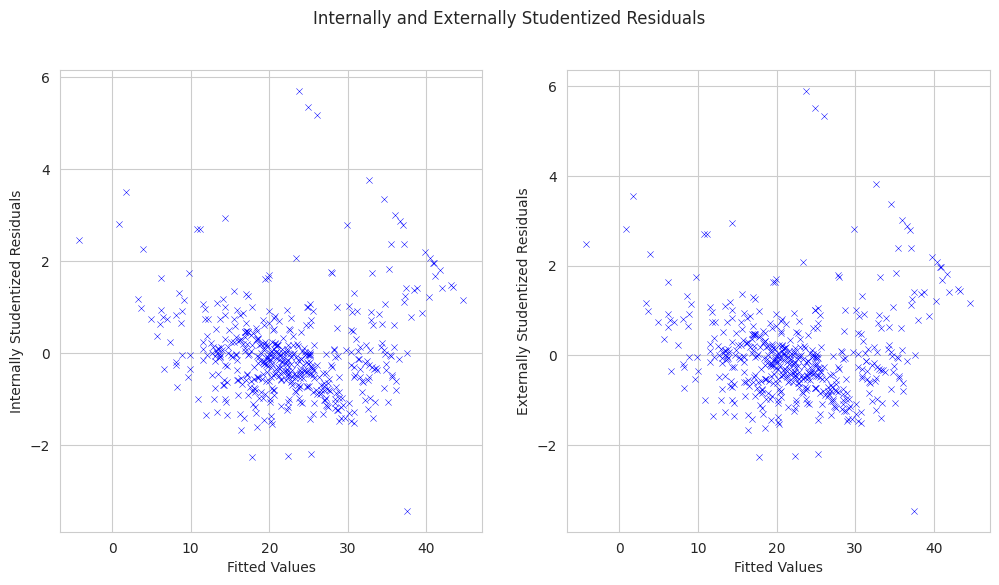

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Internally and Externally Studentized Residuals")

ax[0].set_xlabel(f"Fitted Values")
ax[0].set_ylabel(f"Internally Studentized Residuals")
sns.scatterplot(x=y_hat, y=r, ax=ax[0], s=20, marker='x', color='blue')
# ax[0].axhline(y=0, color='r')
# ax[0].set_ylim(-8, 8)

ax[1].set_xlabel(f"Fitted Values")
ax[1].set_ylabel(f"Externally Studentized Residuals")
sns.scatterplot(x=y_hat, y=t, ax=ax[1], s=20, marker='x', color='blue')

## Removing influential outliers + re-model selection

In [13]:
x_cleaned = x.drop(influential_outliers).reset_index(drop=True)
y_cleaned = y.drop(influential_outliers).reset_index(drop=True)
ps.model_selection(x_cleaned, y_cleaned)
# the same model is the best

,features,beta_hat,sse,sst,ssr,mse,r2,r2_adj,aic_met,sbc_met,k,ck_met
0,"[x1, x2, x4, x5, x6, x8, x9, x10, x11, x12, x13]","[17.529183849183177, -0.07148562372194463, 0.0...",6540.437579,35449.570204,28909.132625,13.682924,81.550023,81.125442,1293.763440,1344.096305,12,12.000000
1,[x1],"[23.85896751294323, -0.5461189052500813]",28400.479870,35449.570204,7049.090334,58.197705,19.884840,19.720670,1993.280406,2001.669216,2,1589.614852
2,[x2],"[20.480945847270938, 0.14385523430449834]",29949.773218,35449.570204,5499.796987,61.372486,15.514425,15.341299,2019.307104,2027.695915,2,1702.843090
3,[x4],"[21.957700650759218, 2.9905752113097472]",35205.557576,35449.570204,244.012628,72.142536,0.688337,0.484830,2098.531383,2106.920194,2,2086.955757
4,[x5],"[41.66217393409619, -35.34638820810184]",27216.142409,35449.570204,8233.427795,55.770784,23.225748,23.068424,1972.408476,1980.797287,2,1503.058976
...,...,...,...,...,...,...,...,...,...,...,...,...
2042,"[x1, x2, x4, x5, x8, x9, x10, x11, x12, x13]","[68.89982487580153, -0.12770854814254176, 0.06...",9693.320418,35449.570204,25756.249786,20.236577,72.656028,72.085173,1484.545591,1530.684050,11,240.424643
2043,"[x1, x2, x4, x6, x8, x9, x10, x11, x12, x13]","[6.715356083998529, -0.056911372712192994, 0.0...",6820.879147,35449.570204,28628.691057,14.239831,80.758923,80.357230,1312.335747,1358.474206,11,30.495734
2044,"[x1, x2, x5, x6, x8, x9, x10, x11, x12, x13]","[17.77637648815788, -0.07366171090756828, 0.03...",6555.503155,35449.570204,28894.067049,13.685810,81.507524,81.121460,1292.890833,1339.029292,11,11.101049
2045,"[x1, x4, x5, x6, x8, x9, x10, x11, x12, x13]","[17.162190292396602, -0.058883139360220646, 0....",6659.537728,35449.570204,28790.032476,13.903002,81.214052,80.821861,1300.605980,1346.744440,11,18.704291


## Fitting model on data without outliers

In [14]:
# fitting the model on cleaned data
features, beta_hat, y_hat, e, sse, sst, ssr, mse, r2, r2_adj, aic_met, sbc_met, p, ck_met = ps.fit_model(x_cleaned, y_cleaned)
print(dict(zip(['r2', 'r2_adj', 'aic_met', 'sbc_met'], [r2, r2_adj, aic_met, sbc_met])))
print(f"Beta hat: {beta_hat}")

{'r2': 81.55002291528682, 'r2_adj': 81.1254418526679, 'aic_met': 1293.7634400351822, 'sbc_met': 1344.096304728438}
Beta hat: [17.529183849183177, -0.07148562372194463, 0.032103316613197236, 0.762857686404478, -12.712829046348777, 5.593858160329078, -1.0492464132043973, 0.19377364570643535, -0.01281867763650333, -0.891605926406815, 0.011999045469470018, -0.3272481292296035]


## Residual plots after cleaning

/tmp/ipykernel_19205/2105199438.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


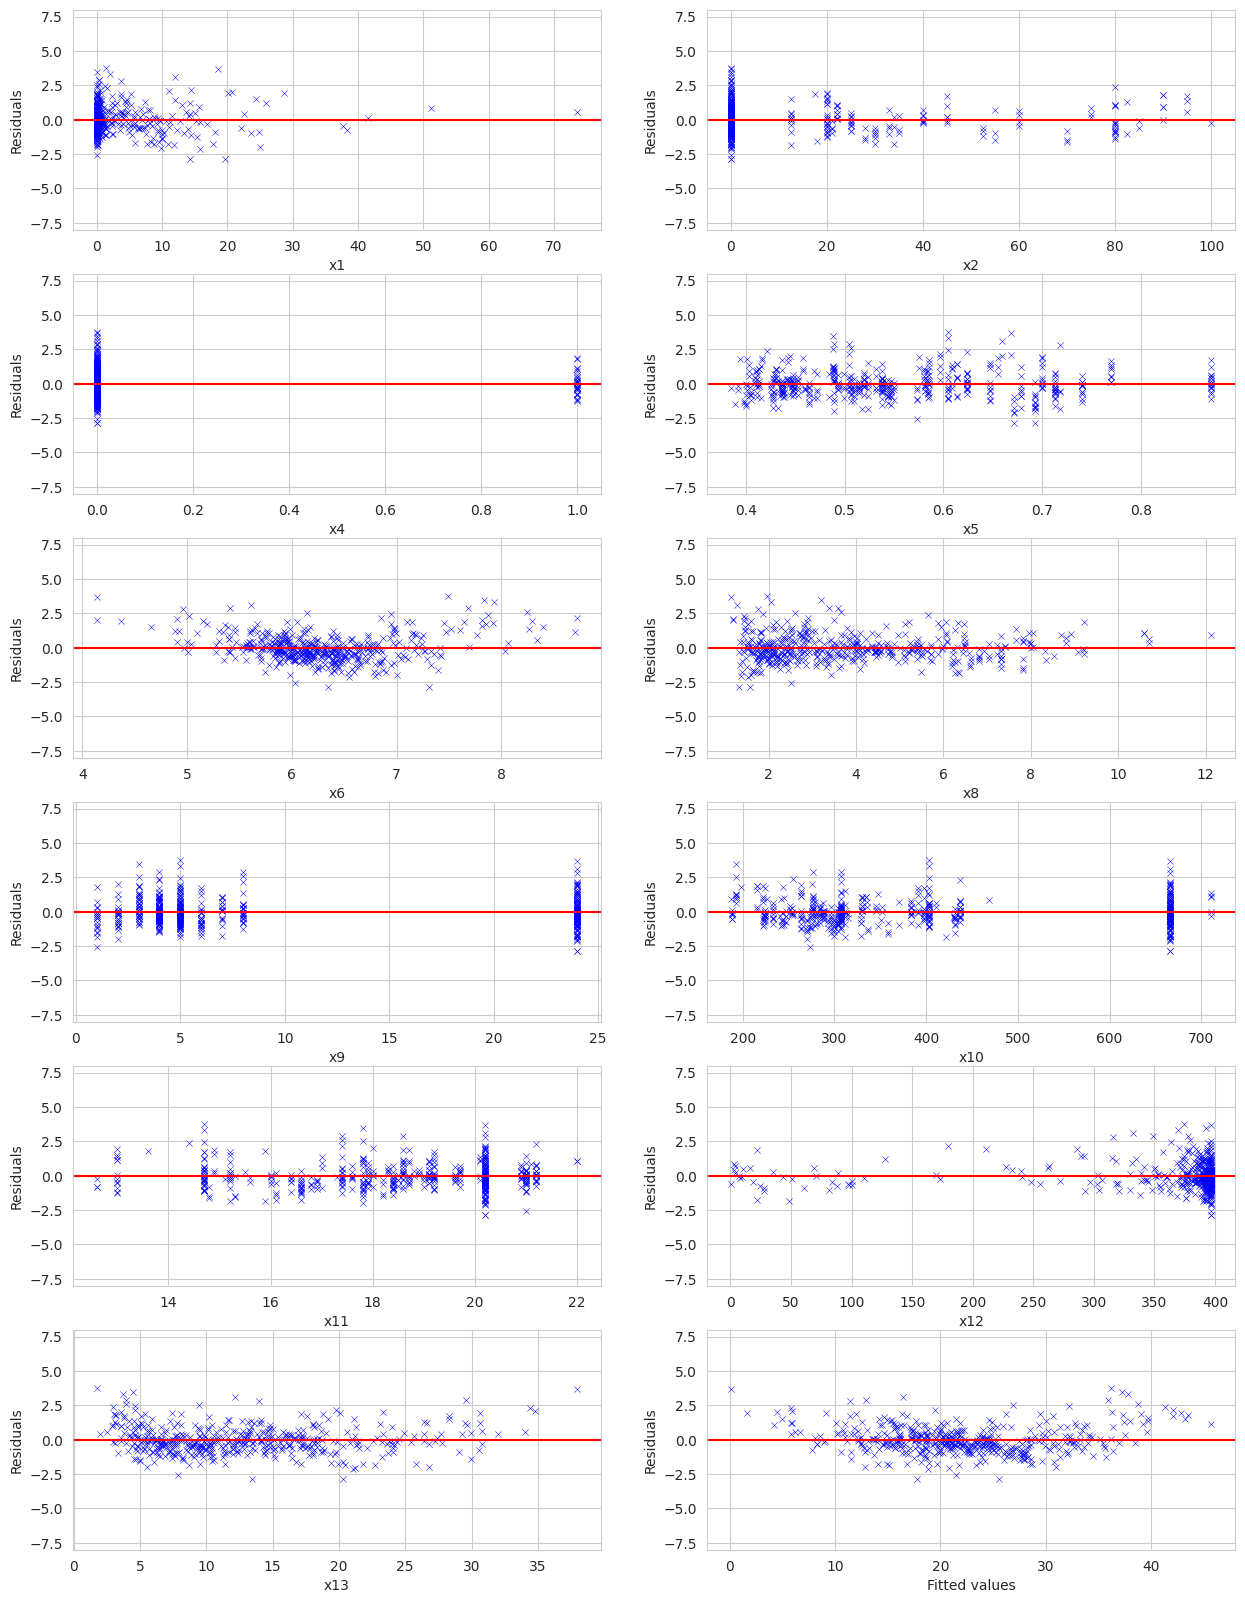

In [15]:
fig, ax = plt.subplots(6, 2, figsize=(15, 20))
e_star = e/np.sqrt(mse)

for i in range(11):
    ax[i//2, i%2].set_xlabel(f"{x_cleaned.columns[i]}")
    ax[i//2, i%2].set_ylabel(f"Residuals")
    sns.scatterplot(x=x_cleaned[x_cleaned.columns[i]], y=e_star, ax=ax[i//2, i%2], s=20, marker='x', color="blue")
    ax[i//2, i%2].axhline(y=0, color='r')
    ax[i//2, i%2].set_ylim(-8, 8)
sns.scatterplot(x=y_hat, y=e_star, ax=ax[5, 1], s=20, marker='x', color="blue")
ax[5, 1].axhline(y=0, color='r')
ax[5, 1].set_xlabel(f"Fitted values")
ax[5, 1].set_ylabel(f"Residuals")
ax[5, 1].set_ylim(-8, 8)

# fig.suptitle("Residual plots")
fig.show()


## Probability plot

Text(0.5, 1.0, 'Residuals Box Plot')

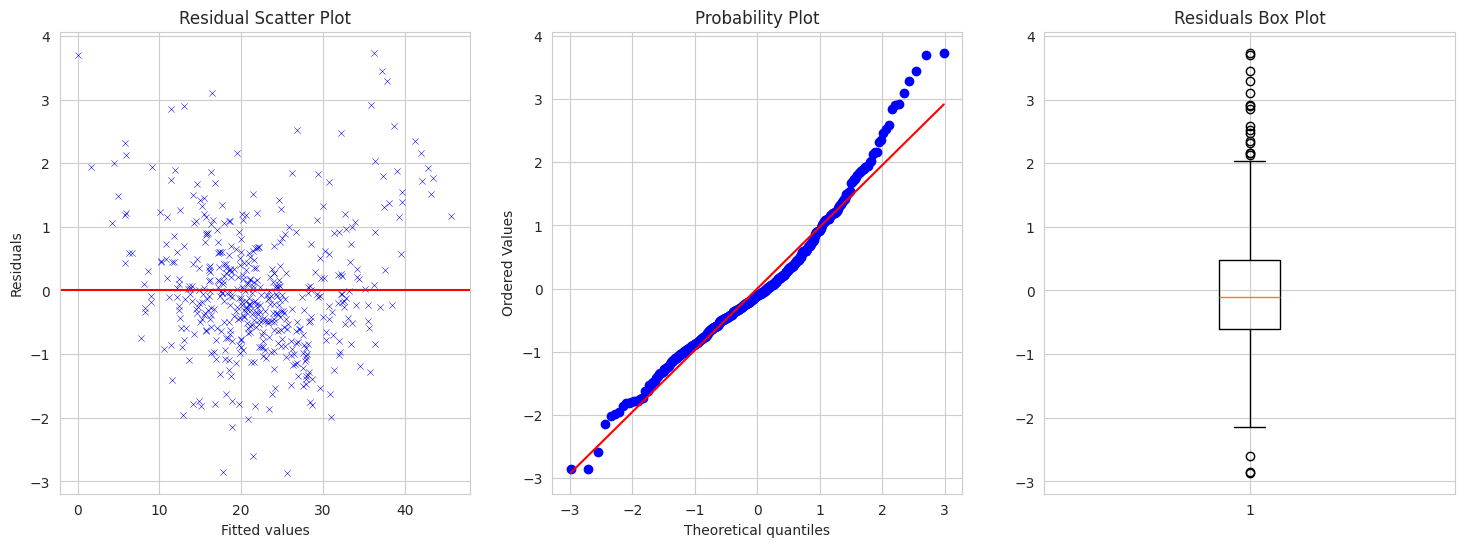

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# ax.set_ylim(-8, 8)
ax[0].axhline(y=0, color='r')
ax[0].set_xlabel(f"Fitted values")
ax[0].set_ylabel(f"Residuals")
ax[0].set_title("Residual Scatter Plot")
sns.scatterplot(x=y_hat, y=e_star, ax=ax[0], s=20, marker="x", color="blue")

stats.probplot(e_star, plot=ax[1])
ax[2].boxplot(e_star);
ax[2].set_title("Residuals Box Plot")

## Breusch-Pagan test

In [17]:
ps.breusch_pagan(x_cleaned, y_cleaned)
#
# H0: constant variance     -       H1: Not constant variance
# since the test statistic is higher than the critical value => reject null hypothesis => non constant variance. it's clear based on the plots anyway.

Test statistic = 88.8897830420216, critical value = 19.67513757268249


## Normality test

In [18]:
# data seems normal. I do shapiro-wilk for surety
shapiro_wilk = stats.shapiro(e)
print(shapiro_wilk)
# p-value is less than 0.05 so it is not normal.

ShapiroResult(statistic=0.9694001899454979, pvalue=1.3817590592397046e-08)


## Model Inferences

In [19]:
is_significant, confidence_intervals = ps.inferences(x_cleaned, y_cleaned)
is_significant

Critical value = 1.9649392716525917
Test statistics: [ 14.75615028  -7.42011556  10.91330146   3.88143991 -16.7463897
  56.15053729 -25.61453542  13.83378357 -17.70506211 -32.41022165
  20.32264498 -29.83040437]


['beta_0 is significant',
 'beta_1 is significant',
 'beta_2 is significant',
 'beta_3 is significant',
 'beta_4 is significant',
 'beta_5 is significant',
 'beta_6 is significant',
 'beta_7 is significant',
 'beta_8 is significant',
 'beta_9 is significant',
 'beta_10 is significant',
 'beta_11 is significant']

# Transformed modeling

## Model selection

In [20]:
# y_star = y**1.5
# y_star = y**1.25
# y_star = y**0.5                   # r_adj=77.06
# y_star = y**2
# y_star = y**(0.2)                 # r2_adj=78.21
# y_star = y**(-2)
# y_star = y_base**(0.1)            # r2_adj=78.389
# y_star = y**(0.95) + y**(-1.05)
# y_star = 1.01**np.sqrt(y)
y_star = y_base.copy()
# y_star = (y_star - 10)**2 - 2 + y_star
# y_star = np.sqrt(y_star + 10) + 2 - y_star    # not bad
# y_star = np.sqrt(y_star + 10) + 2             # not bad
# y_star = np.sqrt(y_star + 10) + 2 - y_star/2    # not bad
# y_star = np.sqrt(y_star + 10) + 2 - y_star/8    # not bad

#'housing_median_age', 'population', 'median_income', 'size_factor', 'density'
x_star = x_base.copy()
x_star['x1'] = 1/(x_star['x1']) + 5
x_star['x8'] = np.sqrt(x_star['x8'] - 0.5)
x_star['x13'] = 1/(x_star['x13']) + 10
# x_star['median_income'] = 2**((x_star['median_income'])-8)

ps.model_selection(x_star, y_star)

,features,beta_hat,sse,sst,ssr,mse,r2,r2_adj,aic_met,sbc_met,k,ck_met
0,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11,...","[-549.4653875349119, -0.017379378840467485, 0....",9474.902515,42716.295415,33241.392900,19.257932,77.818998,77.232914,1510.511726,1569.683240,14,14.000000
1,[x1],"[19.94118357256675, 0.17573003994275196]",38708.168470,42716.295415,4008.126945,76.801922,9.383133,9.203338,2198.658245,2207.111318,2,1507.985734
2,[x2],"[20.917579117799832, 0.14213999415535442]",37166.558224,42716.295415,5549.737191,73.743171,12.992084,12.819450,2178.093765,2186.546838,2,1427.935070
3,[x3],"[29.75489651192849, -0.6484900536157151]",32721.108150,42716.295415,9995.187265,64.922834,23.399003,23.247017,2113.634928,2122.088002,2,1197.097715
4,[x4],"[22.093842887473464, 6.346157112526537]",41404.216144,42716.295415,1312.079271,82.151223,3.071613,2.879295,2232.728270,2241.181344,2,1647.982473
...,...,...,...,...,...,...,...,...,...,...,...,...
8186,"[x1, x2, x3, x4, x6, x7, x8, x9, x10, x11, x12...","[-581.7956152490741, -0.01553587713158427, 0.0...",9951.285456,42716.295415,32765.009959,20.185163,76.703772,76.136724,1533.333694,1588.278671,13,36.736973
8187,"[x1, x2, x3, x5, x6, x7, x8, x9, x10, x11, x12...","[-561.1891091427495, -0.018784977582761153, 0....",9626.373405,42716.295415,33089.922010,19.526112,77.464400,76.915866,1516.536937,1571.481913,13,19.865377
8188,"[x1, x2, x4, x5, x6, x7, x8, x9, x10, x11, x12...","[-548.6803918420748, -0.01593262428117809, 0.0...",9499.061167,42716.295415,33217.234248,19.267873,77.762442,77.221162,1509.800259,1564.745236,13,13.254478
8189,"[x1, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12...","[-550.2360127909014, -0.016334524878586172, -0...",9475.312838,42716.295415,33240.982577,19.219701,77.818037,77.278111,1508.533639,1563.478616,13,12.021307


In [21]:
vif = ps.check_multicollinearity(x_star, x_star.columns)
display(vif)

{'x1': 1.9392960917261775,
 'x2': 2.637079955783861,
 'x3': 4.031498670678378,
 'x4': 1.0794164910093003,
 'x5': 4.582941154395459,
 'x6': 1.906046842528708,
 'x7': 3.0836733570582924,
 'x8': 4.644156772530872,
 'x9': 6.995087907476729,
 'x10': 9.016465982040879,
 'x11': 1.809831101259467,
 'x12': 1.303224092554896,
 'x13': 2.4034515545621207}

## Model fitting

In [22]:
# fitting the model
# x_star = x_star[['x1', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']]       # 83.62 final r2_adj - aic_met': 1233.698, 'sbc_met': 1284.00}
x_star = x_star[['x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']]                     # 83.23 final r2_adj - aic_met': 1215.740, 'sbc_met': 1257.64}
features, beta_hat, y_hat, e, sse, sst, ssr, mse, r2, r2_adj, aic_met, sbc_met, p, ck_met = ps.fit_model(x_star, y_star)
print(dict(zip(['r2', 'r2_adj', 'aic_met', 'sbc_met'], [r2, r2_adj, aic_met, sbc_met])))
print(f"Beta hat: {beta_hat}")

{'r2': 77.7109974457557, 'r2_adj': 77.30655989940853, 'aic_met': 1504.9694810705282, 'sbc_met': 1547.234847763403}
Beta hat: [-552.4547852023404, 2.1617048647680903, -19.128385154098055, 3.344331524957811, -4.556274509254744, 0.21687800370882301, -0.012822991061907985, -0.8632109190718444, 0.01164691241989324, 58.06926825119826]


## Residual plots

/tmp/ipykernel_19205/1280493590.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


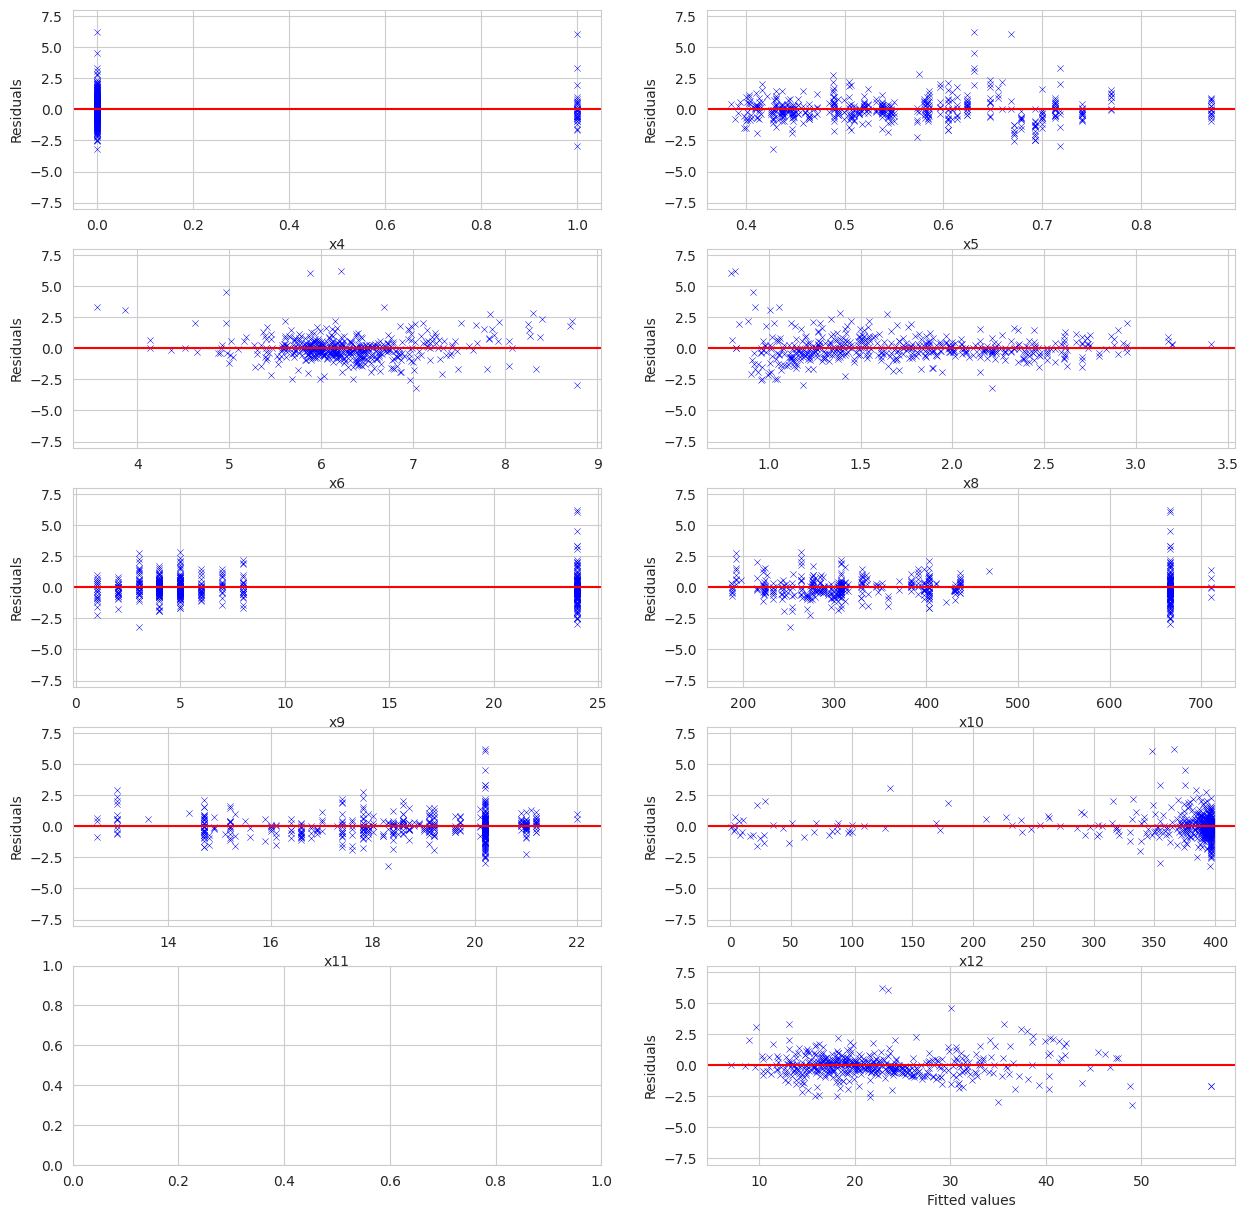

In [23]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
e_star = e/np.sqrt(mse)

for i in range(len(x_star.columns)-1):
    ax[i//2, i%2].set_xlabel(f"{x_star.columns[i]}")
    ax[i//2, i%2].set_ylabel(f"Residuals")
    sns.scatterplot(x=x_star[x_star.columns[i]], y=e_star, ax=ax[i//2, i%2], s=20, marker='x', color="blue")
    ax[i//2, i%2].axhline(y=0, color='r')
    ax[i//2, i%2].set_ylim(-8, 8)
sns.scatterplot(x=y_hat, y=e_star, ax=ax[4, 1], s=20, marker='x', color="blue")
ax[4, 1].axhline(y=0, color='r')
ax[4, 1].set_xlabel(f"Fitted values")
ax[4, 1].set_ylabel(f"Residuals")
ax[4, 1].set_ylim(-8, 8)

fig.show()

## Probability plot

Text(0.5, 1.0, 'Residuals Box Plot')

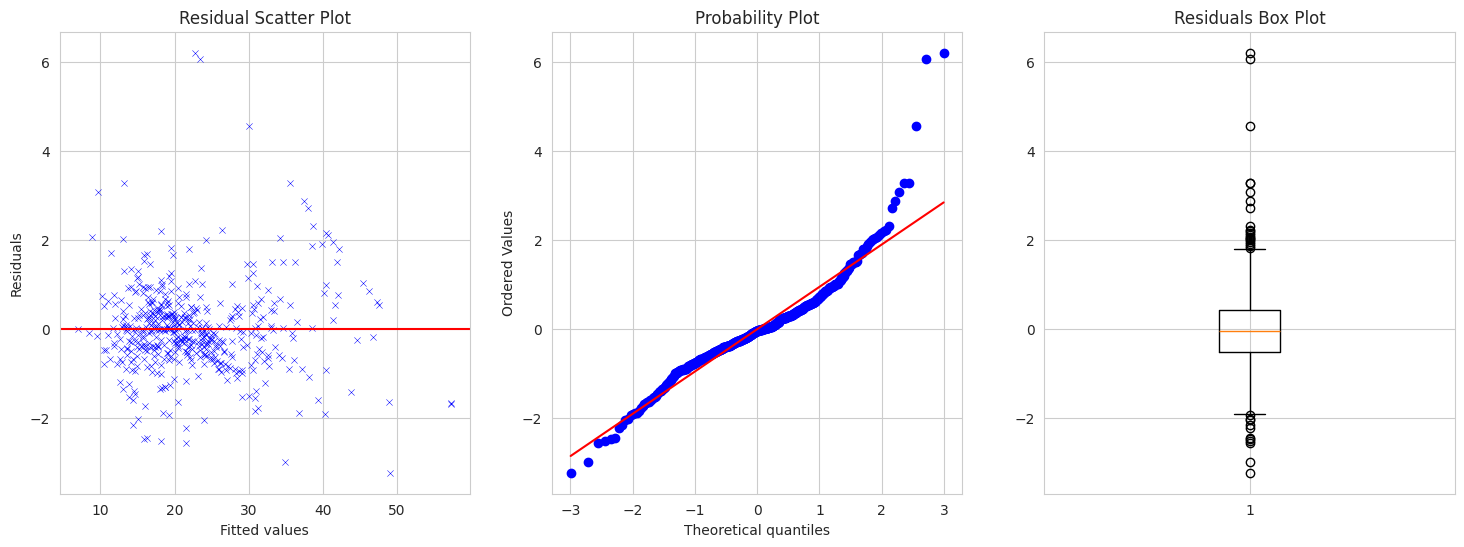

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# ax.set_ylim(-8, 8)
ax[0].axhline(y=0, color='r')
ax[0].set_xlabel(f"Fitted values")
ax[0].set_ylabel(f"Residuals")
ax[0].set_title("Residual Scatter Plot")
sns.scatterplot(x=y_hat, y=e_star, ax=ax[0], s=20, marker="x", color="blue")

stats.probplot(e_star, plot=ax[1])
ax[2].boxplot(e_star);
ax[2].set_title("Residuals Box Plot")

## Outlier detection

In [25]:
x_outliers, y_outliers, influential_outliers, r, t = ps.outlier_detection(x_star, y_star)
print(dict(zip(['x outliers', 'y outliers', 'influential outliers'], [len(x_outliers), len(y_outliers), len(influential_outliers)])))

{'x outliers': 52, 'y outliers': 3, 'influential outliers': 18}


## Residuals for outlier detection

<Axes: xlabel='Fitted Values', ylabel='Externally Studentized Residuals'>

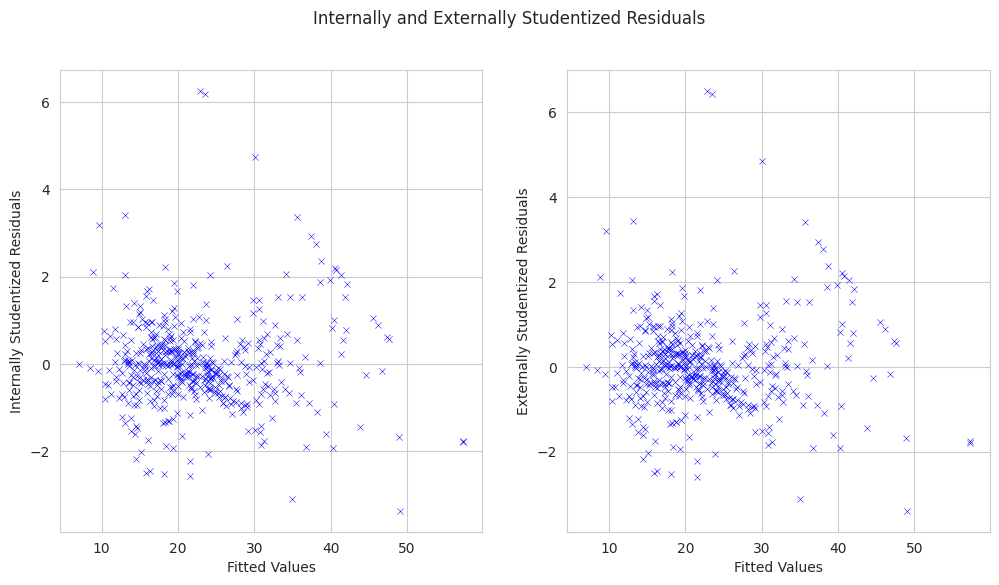

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Internally and Externally Studentized Residuals")

ax[0].set_xlabel(f"Fitted Values")
ax[0].set_ylabel(f"Internally Studentized Residuals")
sns.scatterplot(x=y_hat, y=r, ax=ax[0], s=20, marker='x', color='blue')
# ax[0].axhline(y=0, color='r')
# ax[0].set_ylim(-8, 8)

ax[1].set_xlabel(f"Fitted Values")
ax[1].set_ylabel(f"Externally Studentized Residuals")
sns.scatterplot(x=y_hat, y=t, ax=ax[1], s=20, marker='x', color='blue')

## Removing influential outliers + re-model selection

In [27]:
x_cleaned = x_star.drop(influential_outliers).reset_index(drop=True)
y_cleaned = y_star.drop(influential_outliers).reset_index(drop=True)
ps.model_selection(x_cleaned, y_cleaned)
# the same model is the best

,features,beta_hat,sse,sst,ssr,mse,r2,r2_adj,aic_met,sbc_met,k,ck_met
0,"[x4, x5, x6, x8, x9, x10, x11, x12, x13]","[-503.32226459698967, 1.462829962898999, -12.5...",5656.736021,34365.458832,28708.722811,11.834176,83.539472,83.229546,1215.740019,1257.643173,10,10.000000
1,[x4],"[21.66056644880174, 3.8946059649913614]",33951.727977,34365.458832,413.730855,69.859523,1.203915,1.000631,2074.281256,2082.661887,2,2384.955863
2,[x5],"[42.51582325386707, -37.31022406285208]",25140.777049,34365.458832,9224.681783,51.729994,26.842888,26.692359,1927.662321,1936.042951,2,1640.421466
3,[x6],"[-40.00014084618785, 9.871540070531042]",14763.785057,34365.458832,19601.673774,30.378159,57.038883,56.950485,1667.893145,1676.273775,2,763.554991
4,[x8],"[11.449777660351472, 5.9804656824128255]",29007.815459,34365.458832,5357.643373,59.686863,15.590199,15.416516,1997.482521,2005.863152,2,1967.190181
...,...,...,...,...,...,...,...,...,...,...,...,...
506,"[x4, x5, x6, x8, x10, x11, x12, x13]","[-505.5882119309362, 1.603196510631194, -11.98...",5772.098448,34365.458832,28593.360384,12.050310,83.203779,82.923257,1223.592078,1261.304917,9,17.748243
507,"[x4, x5, x6, x9, x10, x11, x12, x13]","[-487.4823271955098, 1.5310123912628135, -1.32...",6111.340509,34365.458832,28254.118323,12.758540,82.216619,81.919610,1251.461977,1289.174816,9,46.414546
508,"[x4, x5, x8, x9, x10, x11, x12, x13]","[-778.4084767155899, 1.756261305419883, -15.98...",7544.406703,34365.458832,26821.052129,15.750327,78.046542,77.679887,1354.264208,1391.977047,9,167.510110
509,"[x4, x6, x8, x9, x10, x11, x12, x13]","[-540.76932531896, 1.1502681932047676, 4.62284...",5908.241459,34365.458832,28457.217373,12.334533,82.807617,82.520479,1234.968596,1272.681435,9,29.252468


## Fitting model on data without outliers

In [28]:
# fitting the model on cleaned data
features, beta_hat, y_hat, e, sse, sst, ssr, mse, r2, r2_adj, aic_met, sbc_met, p, ck_met = ps.fit_model(x_cleaned, y_cleaned)
print(dict(zip(['r2', 'r2_adj', 'aic_met', 'sbc_met'], [r2, r2_adj, aic_met, sbc_met])))
print(f"Beta hat: {beta_hat}")

{'r2': 83.53947186110075, 'r2_adj': 83.22954559907126, 'aic_met': 1215.7400190513545, 'sbc_met': 1257.643173109886}
Beta hat: [-503.32226459698967, 1.462829962898999, -12.532031933610538, 4.4589200326913785, -3.0654337252849357, 0.14347507220065092, -0.012891380001114783, -0.7446269662272136, 0.011332718797649743, 51.74494904127691]


In [29]:
mse, sse, ssr, sst

(11.834175776355254, 5656.736021097811, 28708.72281086945, 34365.45883196726)

## Residual plots after cleaning

/tmp/ipykernel_19205/2271974138.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


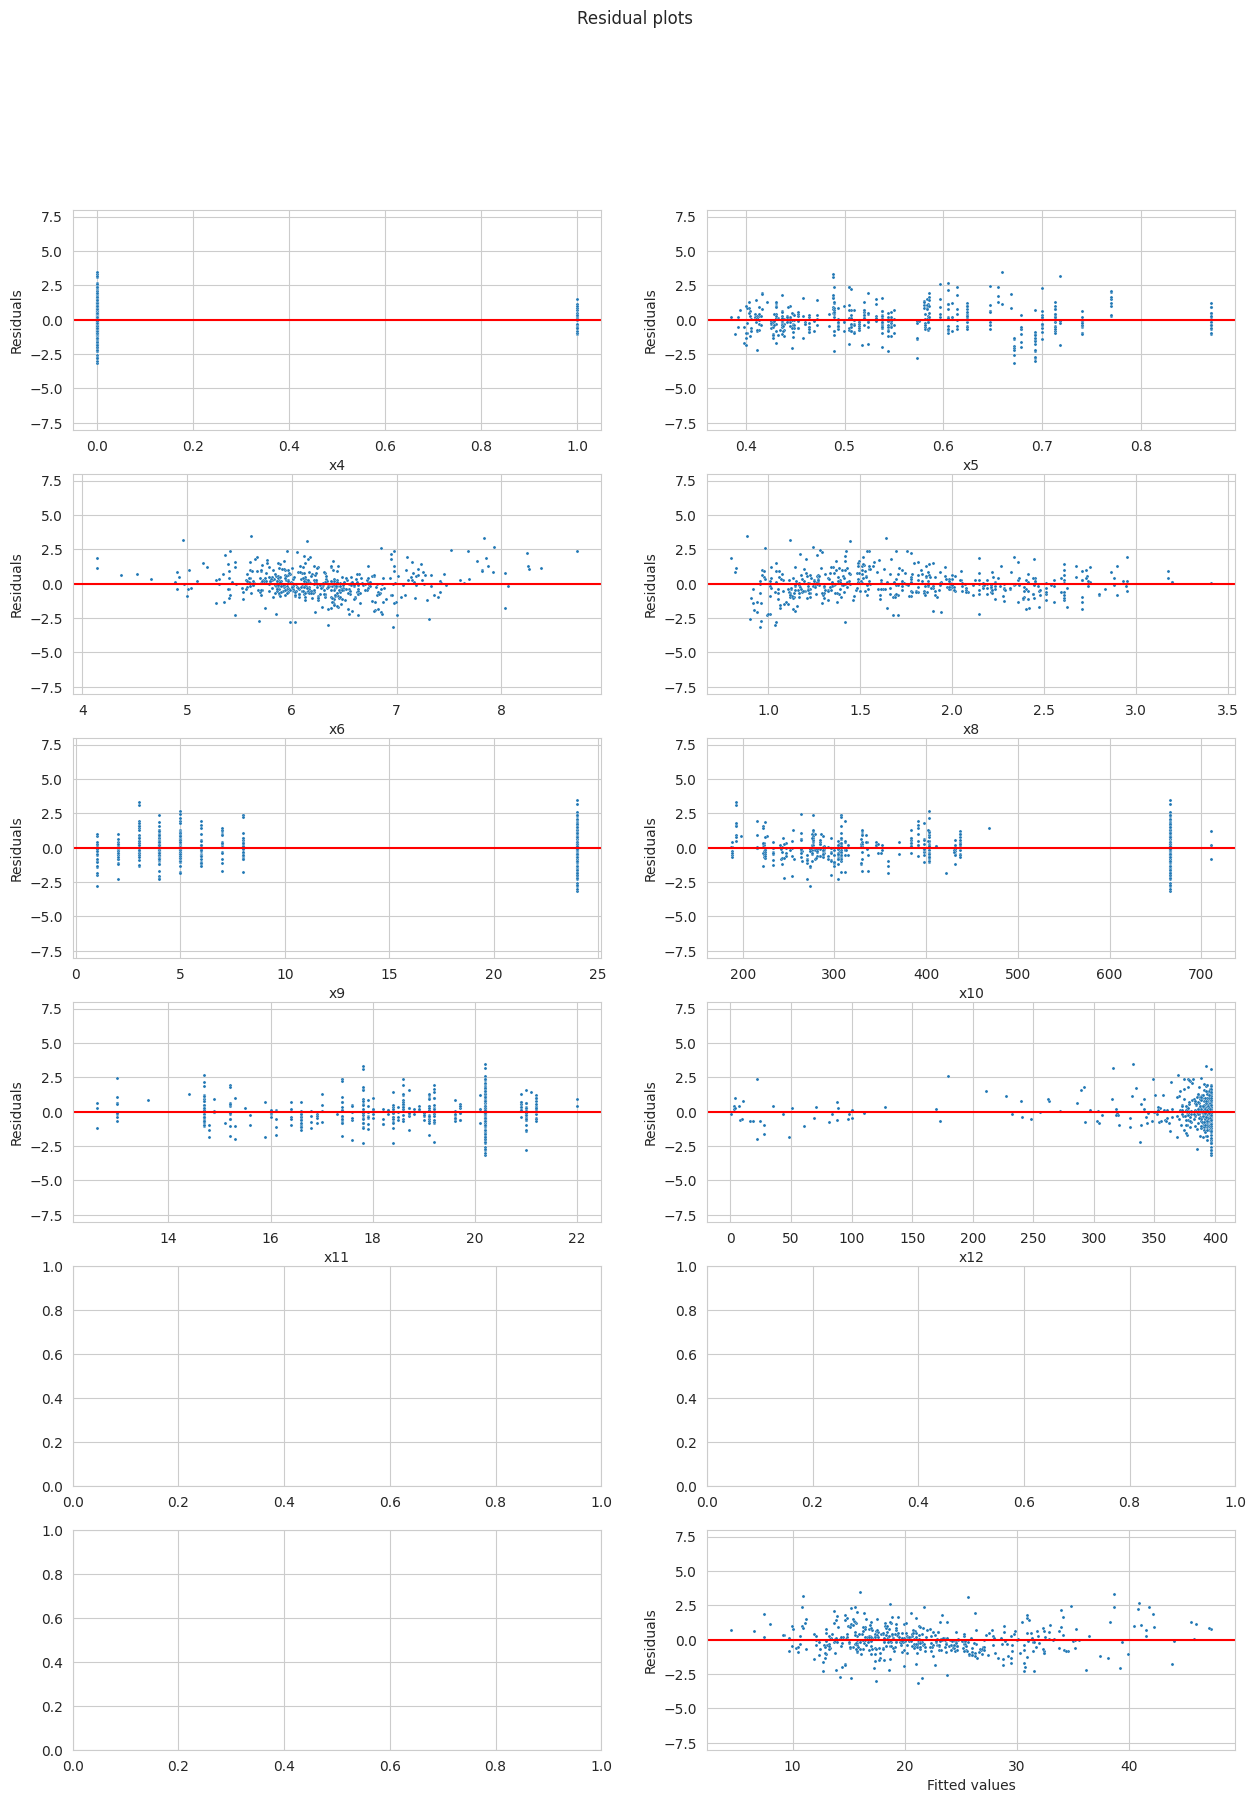

In [30]:
fig, ax = plt.subplots(6, 2, figsize=(15, 20))
e_star = e/np.sqrt(mse)

for i in range(len(x_cleaned.columns)-1):
    ax[i//2, i%2].set_xlabel(f"{x_cleaned.columns[i]}")
    ax[i//2, i%2].set_ylabel(f"Residuals")
    sns.scatterplot(x=x_cleaned[x_cleaned.columns[i]], y=e_star, ax=ax[i//2, i%2], s=5)
    ax[i//2, i%2].axhline(y=0, color='r')
    ax[i//2, i%2].set_ylim(-8, 8)
sns.scatterplot(x=y_hat, y=e_star, ax=ax[5, 1], s=5)
ax[5, 1].axhline(y=0, color='r')
ax[5, 1].set_xlabel(f"Fitted values")
ax[5, 1].set_ylabel(f"Residuals")
ax[5, 1].set_ylim(-8, 8)

fig.suptitle("Residual plots")
fig.show()


## Probability plot

Text(0.5, 1.0, 'Residuals Box Plot')

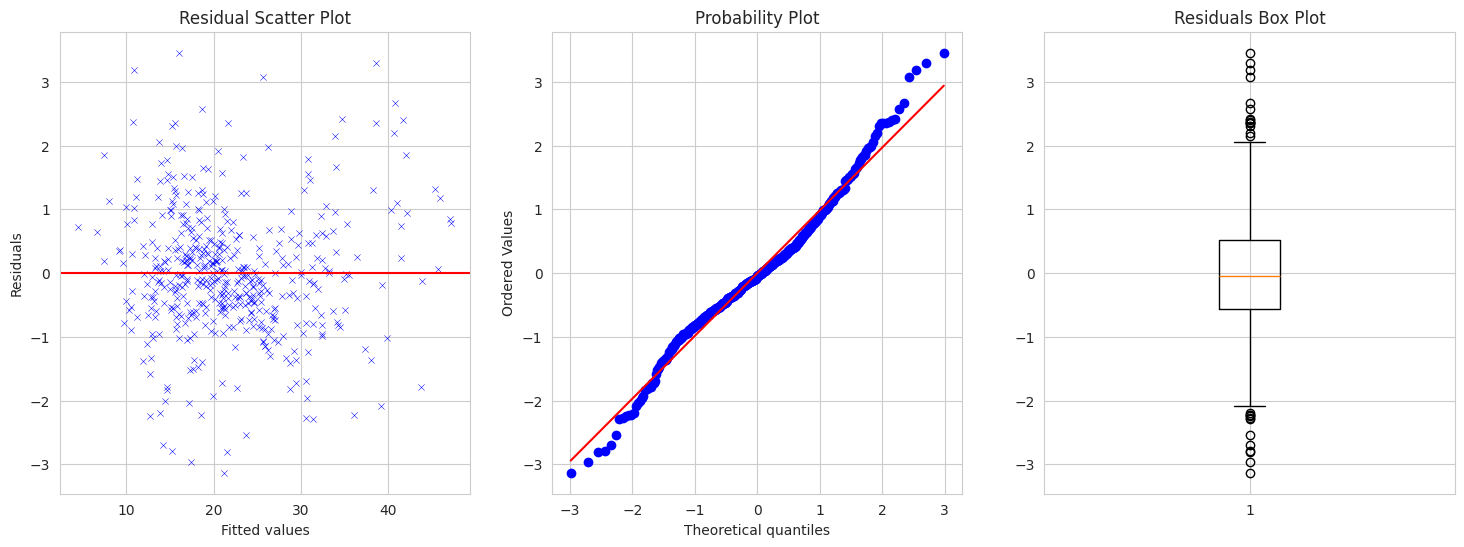

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# ax.set_ylim(-8, 8)
ax[0].axhline(y=0, color='r')
ax[0].set_xlabel(f"Fitted values")
ax[0].set_ylabel(f"Residuals")
ax[0].set_title("Residual Scatter Plot")
sns.scatterplot(x=y_hat, y=e_star, ax=ax[0], s=20, marker="x", color="blue")

stats.probplot(e_star, plot=ax[1])
ax[2].boxplot(e_star);
ax[2].set_title("Residuals Box Plot")

## Breusch-Pagan test

In [32]:
ps.breusch_pagan(x_cleaned, y_cleaned)
#
# H0: constant variance     -       H1: Not constant variance
# since the test statistic is higher than the critical value => reject null hypothesis => non constant variance. it's clear based on the plots anyways.

Test statistic = 110.28339003425455, critical value = 16.918977604620448


## Normality test

In [33]:
# data seems normal. I do shapiro-wilk for surety
shapiro_wilk = stats.shapiro(e)
print(shapiro_wilk)
# p-value is less than 0.05 so it is normal.

ShapiroResult(statistic=0.981599722036053, pvalue=7.64034732325369e-06)


## Model Inferences

In [34]:
is_significant, confidence_intervals = ps.inferences(x_cleaned, y_cleaned)
is_significant
# The transformation made all the values insignificant

Critical value = 1.9649392716525917
Test statistics: [-44.91175671   7.42671054 -15.85892297  43.44733228 -21.32145605
  10.74069022 -17.66215985 -28.18324047  19.93177672  45.74692638]


['beta_0 is significant',
 'beta_1 is significant',
 'beta_2 is significant',
 'beta_3 is significant',
 'beta_4 is significant',
 'beta_5 is significant',
 'beta_6 is significant',
 'beta_7 is significant',
 'beta_8 is significant',
 'beta_9 is significant']